In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import os
import pandas as pd
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.functional import softmax


In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### Setup Model

In [4]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)

### Get Embeddings

In [5]:
df = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.reset_index().rename(columns={'index': 'sku'})[['sku', 'category']]
# Create id2label and label2id mappings
id2label = {i:elem for i,elem in enumerate(df.category.value_counts().index)}
label2id = {elem:i for i,elem in enumerate(df.category.value_counts().index)}
# Map labels to ids
df['label'] = df.category.map(label2id)
# Save to disc
pickle.dump(id2label, open(f"garment_type_id2label.pkl", "wb"))

In [6]:
save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/dinov2_embeddings.pt"
root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"

if not os.path.exists(save_path):
    print('Calculating embeddings from DINOV2 model...')
    embeddings = torch.zeros(df.shape[0], 768)

    for row in tqdm(df.iterrows(), total=df.shape[0]):
        index = row[0]
        sku = row[1]['sku']
        # Load Image and preprocess
        img_path = f"{root_path}{sku}.jpg"
        img = Image.open(img_path).convert('RGB')
        input = processor(img, return_tensors="pt")
        input = input.to(device)
        # Perform forward pass
        with torch.no_grad():
            output = model(**input)
            embedding = output['pooler_output']
        # Assign embedding to embeddings
        embeddings[index,:] = embedding


    # Save embeddings to disc
    torch.save(embeddings, save_path)
else: 
    print('Loading embeddings from disk...')
    embeddings = torch.load(save_path)

Loading embeddings from disk...


### Sanity Check: Nearest Neighbour

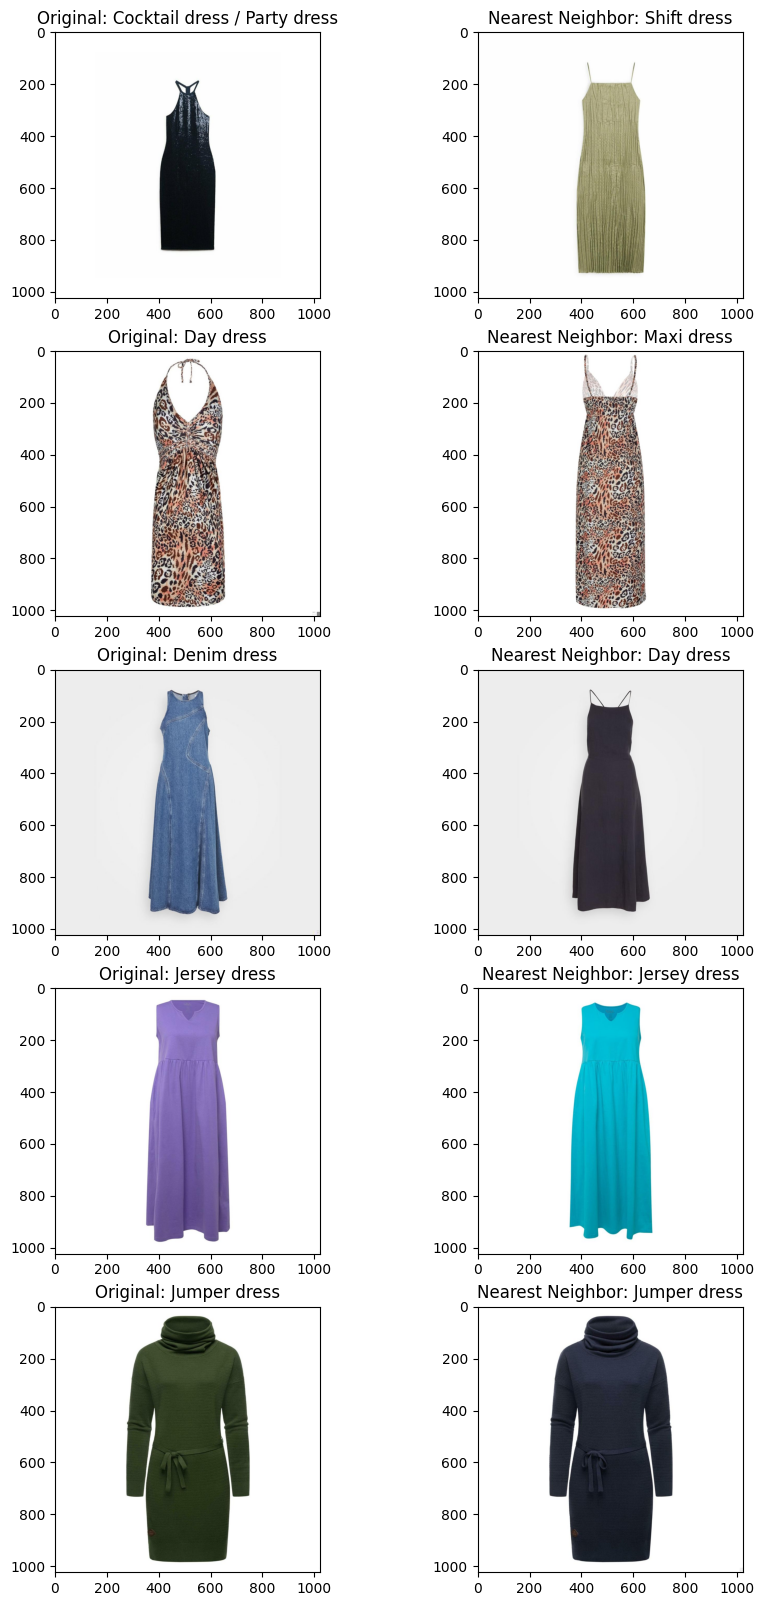

In [7]:
# Visualize Multiple articels and their nearest neighbors
import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
num_samples = 5

fig, axs = plt.subplots(num_samples, 2, figsize=(10, 20))
for i in range(num_samples):
    sample = df.sample(1)
    embedding = embeddings[sample.index.item(),:]
    similarity = cos(embeddings, embedding)
    second_highest = torch.argsort(similarity, descending=True)[1].item()
    second_highest_article = df.iloc[second_highest]
    img_path = f"{root_path}{sample.sku.item()}.jpg"
    img = Image.open(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"Original: {sample.category.item()}")
    img_path = f"{root_path}{second_highest_article.sku}.jpg"
    img = Image.open(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(f"Nearest Neighbor: {second_highest_article.category}")

### Training Preparation

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)
train = train.reset_index().rename(columns={'index': 'index_id'})
test = test.reset_index().rename(columns={'index': 'index_id'})
#train.to_csv("train.csv", index=False)
#test.to_csv("test.csv", index=False)

In [9]:
class DressCategoriesDataset(Dataset):
    """Dress Categories Dataset"""

    def __init__(self, df, embeddings):
        self.df = df
        self.embeddings = embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        index_id = self.df.iloc[idx]['index_id']

        label = self.df[self.df.index_id == index_id]['label'].values[0]
        embedding = self.embeddings[index_id,:]

        return embedding, label


In [10]:
train_dataset = DressCategoriesDataset(train, embeddings)
test_dataset = DressCategoriesDataset(test, embeddings)

### Model Setup

In [11]:
import torch.nn as nn
class ClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierModel, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [12]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            embeddings, labels = data
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Weights&Biases Tuning

In [13]:
import wandb

# Sweep configuration dictionary
sweep_config = {
    'method': 'random',  # or 'bayes', 'grid', for different search strategies
    'metric': {
        'name': 'test_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01]
        },
        'batch_size': {
            'values': [8, 16, 32, 64]
        },
        'optimizer': {
            'values': ['adam', 'adamw', 'sgd']
        },
        'epochs': {
            'values': [5, 10, 20]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DinoV2_Embeddings_Classifier")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: lk5gv2h3
Sweep URL: https://wandb.ai/malte_/DinoV2_Embeddings_Classifier/sweeps/lk5gv2h3


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

def train():
    # Initialize a new W&B run
    wandb.init()

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    model = ClassifierModel(768, len(label2id)).to(device)
    loss_fn = nn.CrossEntropyLoss()

    # Select optimizer based on wandb config
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    for epoch in range(config.epochs):
        model.train()
        for embeddings, labels in train_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate and log metrics with W&B
        train_acc = evaluate_model(model, train_loader)
        test_acc = evaluate_model(model, test_loader)
        #print(test_acc)
        wandb.log({'epoch': epoch, 'loss': loss.item(), 'train_accuracy': train_acc, 'test_accuracy': test_acc})

    # Save the model
    wandb.save('model.pth')

# Start the sweep
# wandb.agent(sweep_id, train)


### Train with best hyperparamaters

In [15]:
# NUM_EPOCHS = 20
# BATCH_SIZE = 32
# LR = 0.01

# loss_fn = nn.CrossEntropyLoss()
# model = ClassifierModel(embeddings.shape[1], len(label2id)).to(device)
# optimizer = optim.SGD(model.parameters(), lr=LR)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     for embeddings, labels in train_loader:
#         embeddings = embeddings.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(embeddings)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Training Set accuracy
#     train_acc = evaluate_model(model, train_loader)

#     # Test Set accuracy
#     test_acc = evaluate_model(model, test_loader)

#     print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")

# torch.save(model, f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_mlp_classifier.pt")

### Check Model Performance

In [16]:
model = torch.load(f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_mlp_classifier.pt")
model = model.to(device)

embeddings = torch.load(f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/dinov2_embeddings.pt")
embedding = embeddings.to(device)

In [17]:
for i in tqdm(range(df.shape[0])):
    embedding = embeddings[i,:]
    embedding = embedding.to(device)
    label = df.iloc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.max(softmax(output.data, 0), 0)
        df.loc[i, 'predicted_label'] = predicted.item()
        df.loc[i, 'predicted_prob'] = prob.item()

df['predicted_category'] = df.predicted_label.map(id2label)

  0%|          | 0/14060 [00:00<?, ?it/s]

In [18]:
train_acc = evaluate_model(model, DataLoader(train_dataset, batch_size=32, shuffle=False))
test_acc = evaluate_model(model, DataLoader(test_dataset, batch_size=32, shuffle=False))
print(f"Train Accuracy: {np.round(train_acc*100, 2)}%, Test Accuracy: {np.round(test_acc*100, 2)}%")

Train Accuracy: 82.39%, Test Accuracy: 67.99%


In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score
overall_accuracy = accuracy_score(df['label'], df['predicted_label'])
print(f"Overall Accuracy: {overall_accuracy:.2%}")

Overall Accuracy: 79.51%


In [20]:
# Function to calculate accuracy for a group
def category_accuracy(group):
    return accuracy_score(group['label'], group['predicted_label'])

# Calculate accuracy for each category
category_accuracy = df.groupby('category').apply(category_accuracy).sort_values(ascending=False)

# Print the accuracy for each category
print("Accuracy by Category:")
print(category_accuracy)

Accuracy by Category:
category
Denim dress                     0.951923
Jumper dress                    0.946707
Occasion wear                   0.898409
Day dress                       0.858806
Maxi dress                      0.726409
Cocktail dress / Party dress    0.715742
Shift dress                     0.623512
Jersey dress                    0.564804
dtype: float64


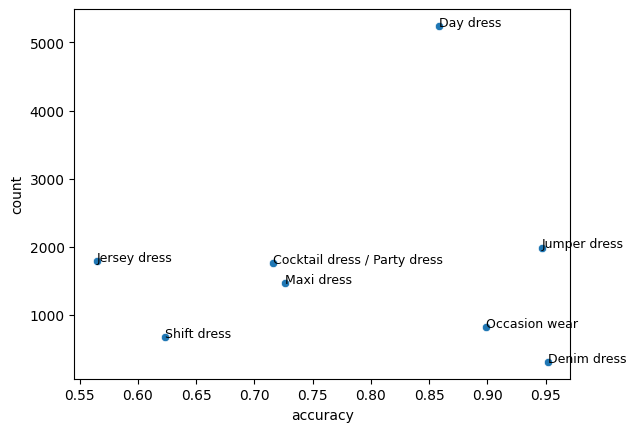

In [21]:
plot_data = pd.DataFrame(category_accuracy).reset_index().rename(columns={0: 'accuracy'}).merge(df.category.value_counts().reset_index())
# Plot accuracy against number of samples and name each dot
plt.figure()
import seaborn as sns
sns.scatterplot(data=plot_data, x='accuracy', y='count')
for i in range(plot_data.shape[0]):
    plt.text(plot_data.accuracy[i], plot_data['count'][i], plot_data['category'][i], fontsize=9)

In [22]:
# Print confusion matrix
confusion_matrix = pd.crosstab(df['predicted_category'], df['category'], rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
Predicted,,,,,,,,
Cocktail dress / Party dress,1264,88,0,27,11,20,23,34
Day dress,209,4501,9,398,37,238,15,38
Denim dress,2,29,297,1,0,5,0,2
Jersey dress,46,140,0,1011,32,23,2,64
Jumper dress,48,191,2,205,1883,34,7,107
Maxi dress,34,211,1,70,14,1070,35,7
Occasion wear,108,25,1,32,4,77,734,1
Shift dress,55,56,2,46,8,6,1,419


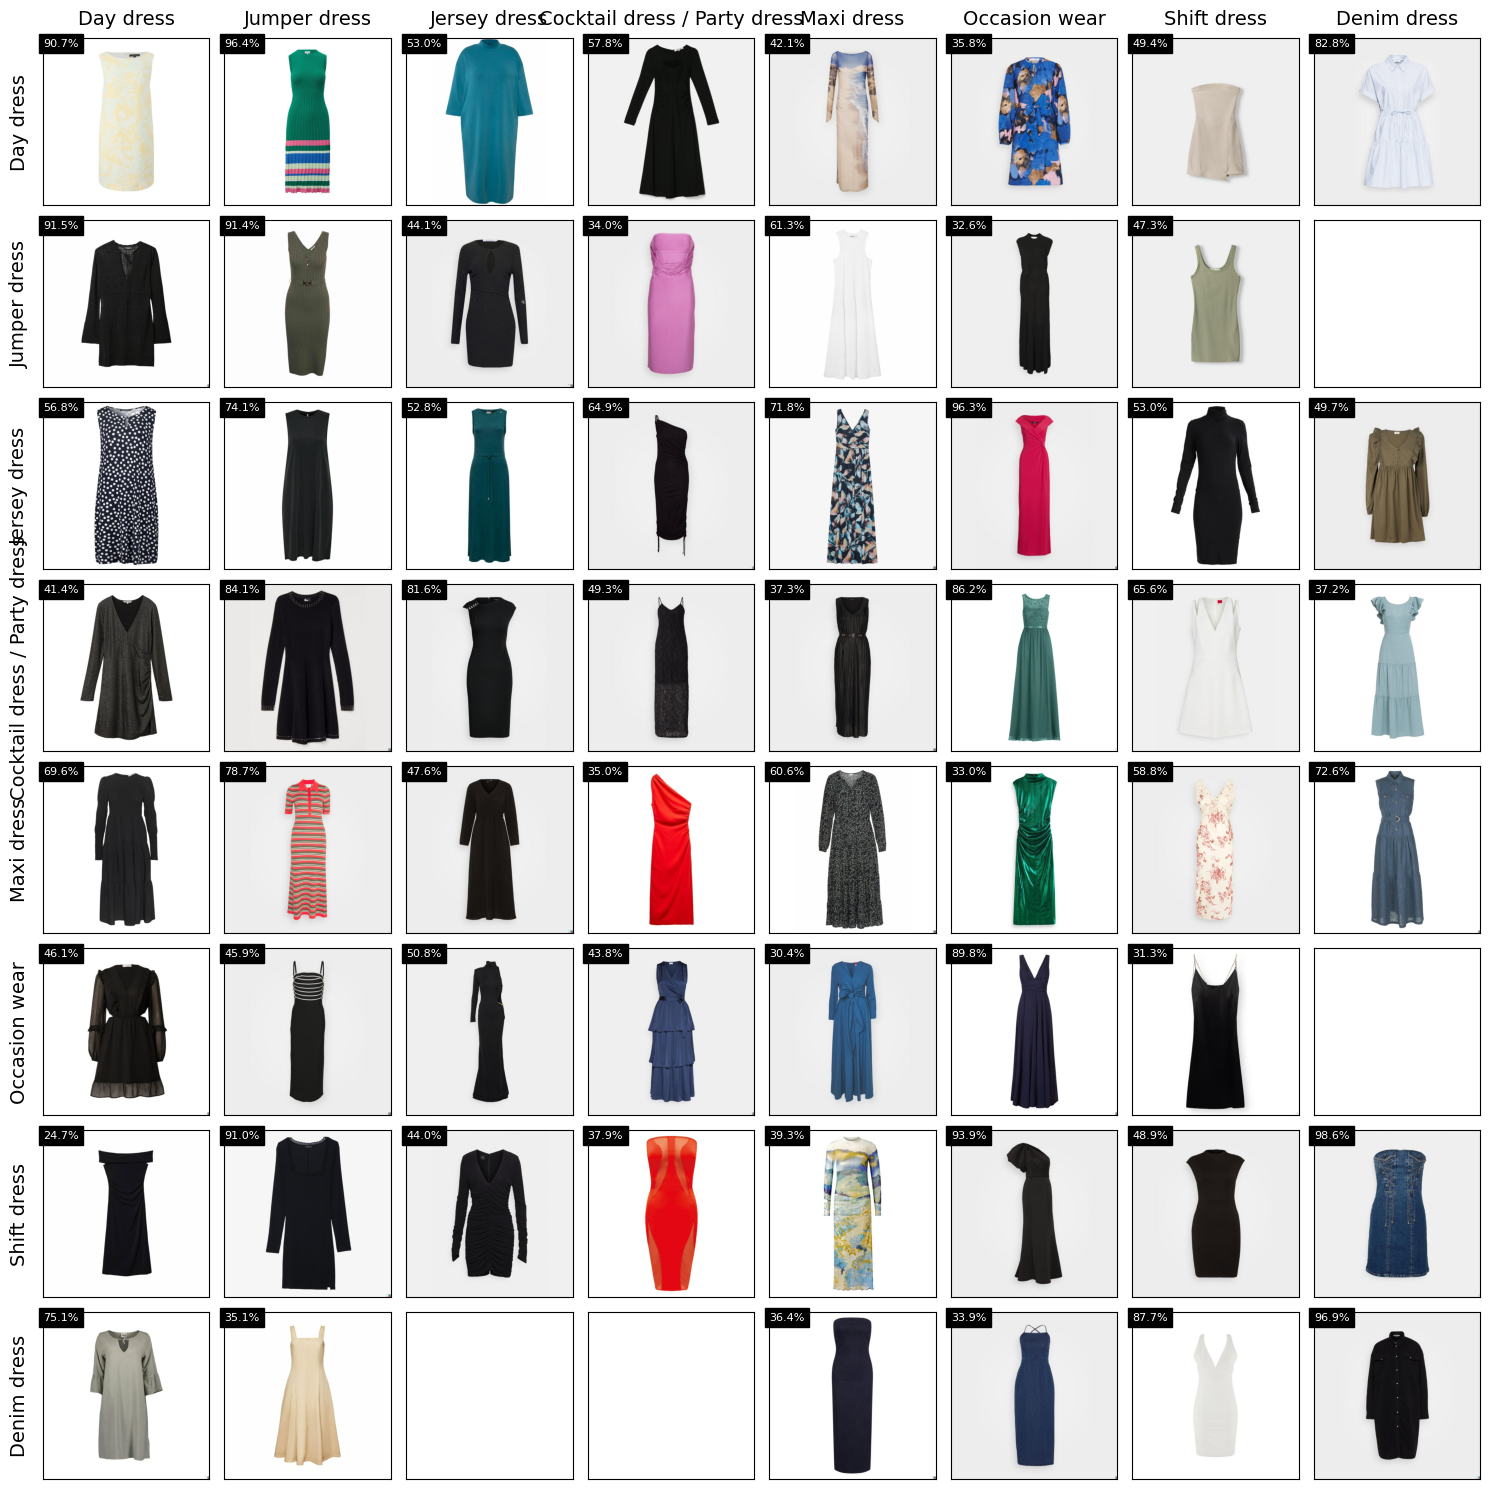

In [23]:
# Below I will plot some examples of images and their predicted labels. 
# The columns will be the actual classes
# The rows will be the predicted classes
# For each combination there will be one random sample image displayed
# The title will be the probability of the predicted class
# If there are no samples in the class, the plot will be empty
# The columns are titled with the actual class
# The rows are titled with the predicted class
fig, axs = plt.subplots(len(id2label), len(id2label), figsize=(15, 15))

for i in range(len(id2label)):  # rows in the subplot grid
    for j in range(len(id2label)):  # columns in the subplot grid
        subset = df[(df['label'] == j) & (df['predicted_label'] == i)]
        if not subset.empty:
            sample = subset.sample(1)
            img_path = f"{root_path}{sample['sku'].item()}.jpg"
            img = Image.open(img_path)
            axs[j, i].imshow(img)
            axs[j, i].text(0, 0, f'{np.round(sample.predicted_prob.item()*100,1)}%', color='white', backgroundcolor='black', fontsize=8, verticalalignment='top')
        #axs[j, i].axis('off')
        axs[j, i].set_xticks([])  # Ensure no ticks
        axs[j, i].set_yticks([])
        axs[j, 0].set_ylabel(id2label[j], labelpad=10, fontsize=14)


    # Set labels with a larger font and some padding for better visibility
    axs[0, i].set_title(id2label[i], pad=10, fontsize=14)
    



plt.tight_layout()
plt.show()
